In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
from functions import *
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
data = pd.read_csv('./data/data.csv')

In [3]:
data=data.rename(columns = {"Unnamed: 0": "Date"})

In [4]:
data.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
146659,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
146660,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
146661,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
146662,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
146663,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [5]:
data.Date = pd.to_datetime(data.Date)

In [6]:
data.set_index('Date', inplace = True)

In [7]:
data.sort_index(inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.7 MB


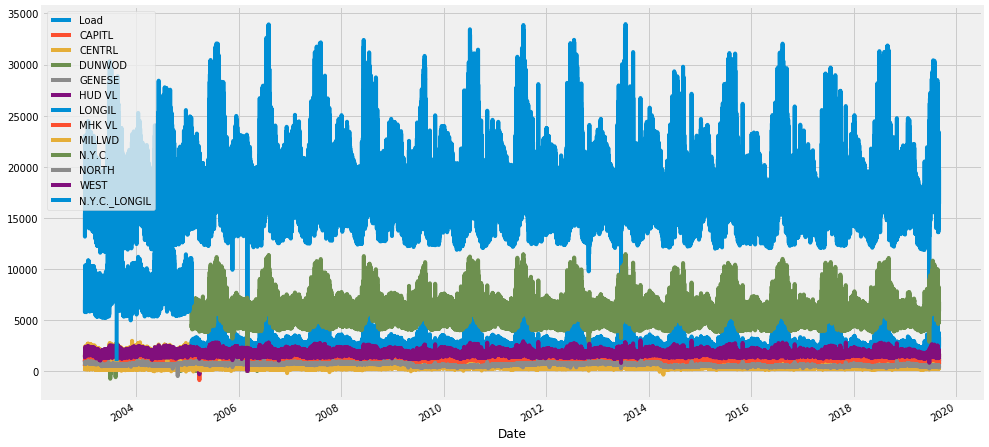

In [9]:
data.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [10]:
data.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    128439
dtype: int64

In [11]:
#drop NaNs
target = 'Load'
_id='date'
data.dropna(subset = [target], inplace=True)
data.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127809
dtype: int64

In [12]:
data.shape

(146034, 13)

In [13]:
drop_cols = [col for col in data.columns.tolist() if col not in [target]]

In [14]:
data.drop(drop_cols, axis=1, inplace=True)

In [15]:
data.head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [16]:
data = create_features(data, target)

In [17]:
data.dropna(inplace=True)

In [20]:
reg = xgb.XGBRegressor()

In [21]:
splits = create_split(data, 10)
smapes=[]
smapes_daily=[]
smape_list = []
smape_list_daily = []
for start, end in splits:
    sample = data[start:end]
    split_at = int(len(sample) * 0.8)
    train, keep_cols, used_cols = data_prep(sample[:split_at], target, _id)
    X_train = train[used_cols].iloc[:-(24),:]
    y_train = train[target].shift(-(24)).dropna()
    test, keep_cols, used_cols = data_prep(sample[split_at:], target, _id)
    X_test = test[used_cols].iloc[:-(24),:]
    y_test = test[target].shift(-(24)).dropna()
    reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train)],
        eval_metric = 'mae',
        early_stopping_rounds=25, 
        verbose=False)
    y_pred = reg.predict(X_test)
    s = symmetric_mape(y_test, y_pred)
    s_1 = symmetric_mape(y_test[:24], y_pred[:24])
    smape_list.append(s)
    smape_list_daily.append(s_1)
    avg = sum(smape_list)/len(smape_list)
    avg_daily=sum(smape_list_daily)/len(smape_list_daily)
    smapes.append(avg)
    print("SMAPE per fold: ", s, "\n")
    print("SMAPE first day per fold: ",s_1,"\n")
    print("First Day Average : ", avg_daily)
    print("Average : ", avg)
    print("\n")
    

SMAPE per fold:  8.145284409101576 

SMAPE first day per fold:  4.537650638810371 

First Day Average :  4.537650638810371
Average :  8.145284409101576


SMAPE per fold:  4.278407945080446 

SMAPE first day per fold:  5.166146829616068 

First Day Average :  4.851898734213219
Average :  6.211846177091012


SMAPE per fold:  3.555589440041134 

SMAPE first day per fold:  5.736225447148597 

First Day Average :  5.146674305191678
Average :  5.326427264741052


SMAPE per fold:  3.583918228673667 

SMAPE first day per fold:  1.490323463270345 

First Day Average :  4.2325865947113455
Average :  4.890800005724206


SMAPE per fold:  4.342760267891994 

SMAPE first day per fold:  2.3715593488096407 

First Day Average :  3.8603811455310044
Average :  4.781192058157763


SMAPE per fold:  3.852039786814301 

SMAPE first day per fold:  12.247366078363214 

First Day Average :  5.258211967669706
Average :  4.626333346267186


SMAPE per fold:  3.9631907295589595 

SMAPE first day per fold:  2.04842

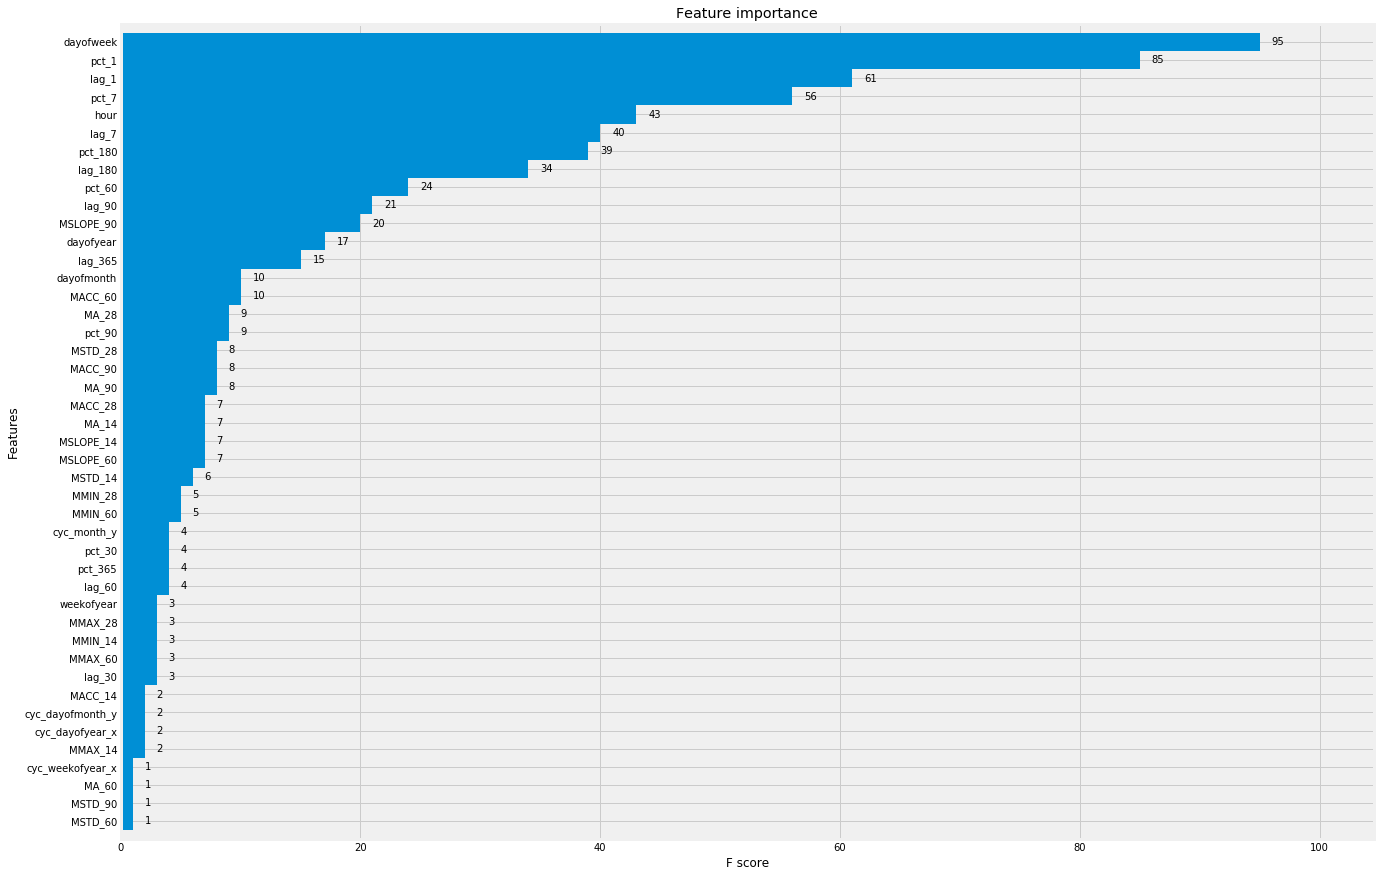

In [22]:
plt.rcParams["figure.figsize"] = (20, 15)
xgb.plot_importance(reg, height = 1)

In [26]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

1343729.4862792136


In [27]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

843.6032713661331


In [28]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

4.517549774451659


In [29]:
sMAPE = symmetric_mape(y_test, y_pred)
print(sMAPE)

4.494039019421789


In [30]:
sMAPE = symmetric_mape(y_test[:(24)], y_pred[:(24)])
print(sMAPE)

4.453572310274422


In [31]:
RMSE = np.sqrt(MSE)
print(RMSE)

1159.193463697589


In [32]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

-32.05868960526904


In [33]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.8877729707645812


In [34]:
X_test.head(10)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-13 22:00:00,22,2,3,7,2016,195,13,28,20620.609314,29670.008333,...,23895.191667,1.018012,1.0,-4.898587e-16,0.885456,4.647232e-01,0.899968,0.435956,-1.0,1.224647e-16
2016-07-13 23:00:00,23,2,3,7,2016,195,13,28,20628.931934,29670.008333,...,22618.008333,1.041744,1.0,-4.898587e-16,0.885456,4.647232e-01,0.899968,0.435956,-1.0,1.224647e-16
2016-07-14 00:00:00,0,3,3,7,2016,196,14,28,20637.472831,29670.008333,...,20879.250000,1.032993,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16
2016-07-14 01:00:00,1,3,3,7,2016,196,14,28,20646.080569,29670.008333,...,19396.883333,1.006888,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16
2016-07-14 02:00:00,2,3,3,7,2016,196,14,28,20654.687340,29670.008333,...,18349.983333,0.988180,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16
2016-07-14 03:00:00,3,3,3,7,2016,196,14,28,20663.430817,29670.008333,...,17629.933333,0.967496,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16
2016-07-14 04:00:00,4,3,3,7,2016,196,14,28,20672.501750,29670.008333,...,17184.558333,0.942461,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16
2016-07-14 05:00:00,5,3,3,7,2016,196,14,28,20682.480371,29670.008333,...,17087.666667,0.905936,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16
2016-07-14 06:00:00,6,3,3,7,2016,196,14,28,20692.977420,29670.008333,...,17583.508333,0.869885,1.0,-4.898587e-16,1.000000,-2.449294e-16,0.900969,0.433884,-1.0,1.224647e-16


In [35]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02 12:00:00,12,4,1,1,2004,2,2,1,17193.743225,22440.071429,...,15415.625000,0.813243,1.0,-4.898587e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-4.898587e-16
2004-01-02 13:00:00,13,4,1,1,2004,2,2,1,17190.266836,22440.071429,...,14569.928571,0.776420,1.0,-4.898587e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-4.898587e-16
2004-01-02 14:00:00,14,4,1,1,2004,2,2,1,17186.624773,22440.071429,...,13812.200000,0.743636,1.0,-4.898587e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-4.898587e-16
2004-01-02 15:00:00,15,4,1,1,2004,2,2,1,17182.505155,22440.071429,...,13315.333333,0.717346,1.0,-4.898587e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-4.898587e-16
2004-01-02 16:00:00,16,4,1,1,2004,2,2,1,17177.015795,22440.071429,...,13156.333333,0.682110,1.0,-4.898587e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-4.898587e-16


In [38]:
X_train.shape

(109795, 54)

In [39]:
y_train.shape

(109795,)

In [40]:
X_test.shape

(27431, 54)

In [41]:
y_test.shape

(27431,)

In [37]:
y_pred.shape

(27431,)

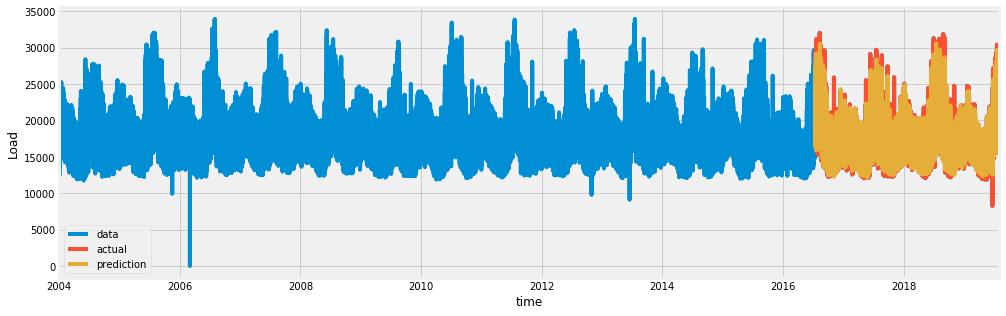

In [43]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Load')
# plt.title("")
plt.plot(data.iloc[:-(24),:].index, data[target].shift(-(24)).dropna(), '-', label='data')
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='01-02-2004', right='07-31-2019')
plt.show()

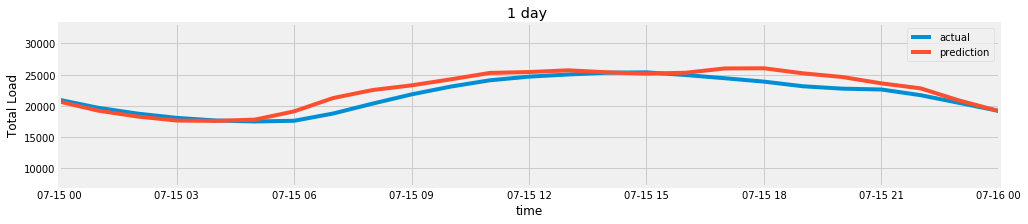

In [59]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("1 day ")
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-16-2016')
plt.show()
# plot_(X_test, y_test, '06-23-2019', y_test.index[48], "1 day ")

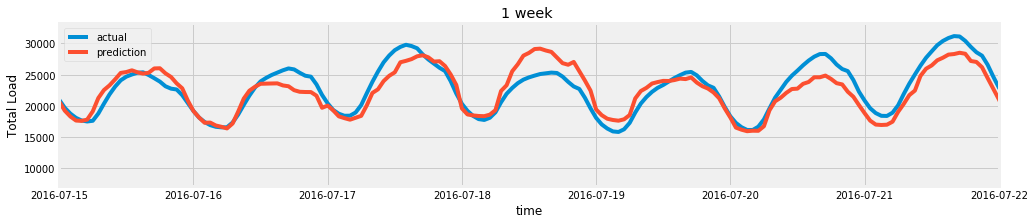

In [60]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("1 week ")
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-22-2016')
plt.show()

In [46]:
day_fcst = y_pred[:50]
act_ = y_test[:50]
act_2 = y_test[:26]

In [47]:
dm = X_test.copy()

In [48]:
dm=dm.reset_index()

In [49]:
x_vals = dm['Date'].shift(-24).dropna()

In [50]:
x_ = x_vals[:50]

In [51]:
x_2 = x_vals[:26]

In [52]:
len(y_test[:55])

55

In [53]:
len(act_)

50

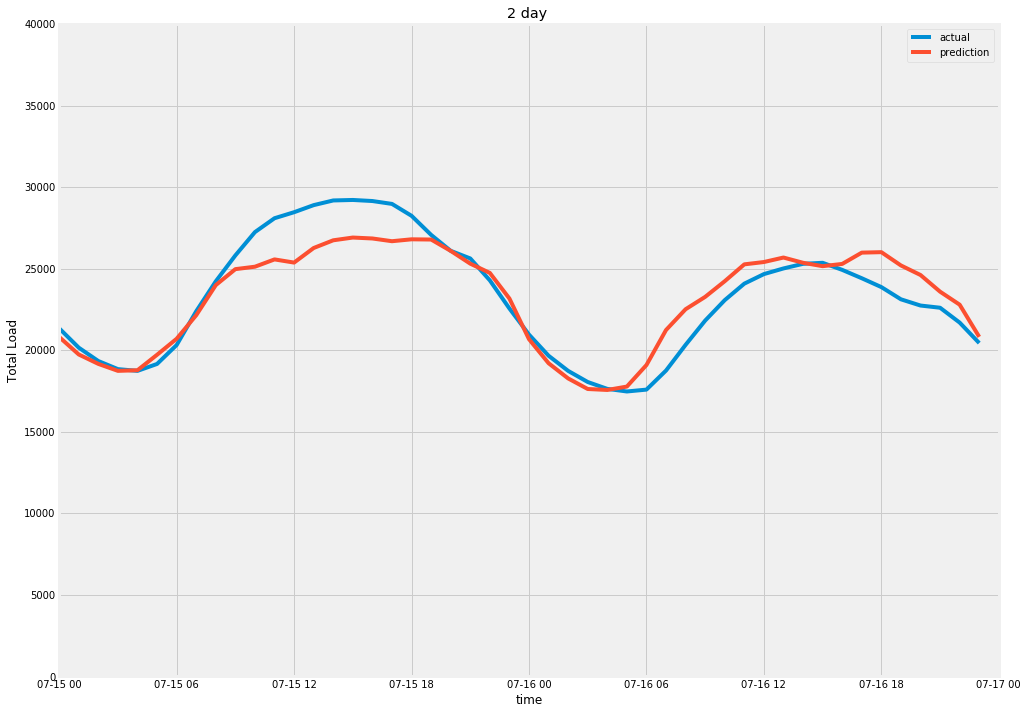

In [65]:
plt.figure(figsize=(15,12))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("2 day ")
plt.plot(x_, act_, '-', label='actual')
plt.plot(x_, day_fcst, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-17-2016')
plt.ylim(0,40000)
plt.show()

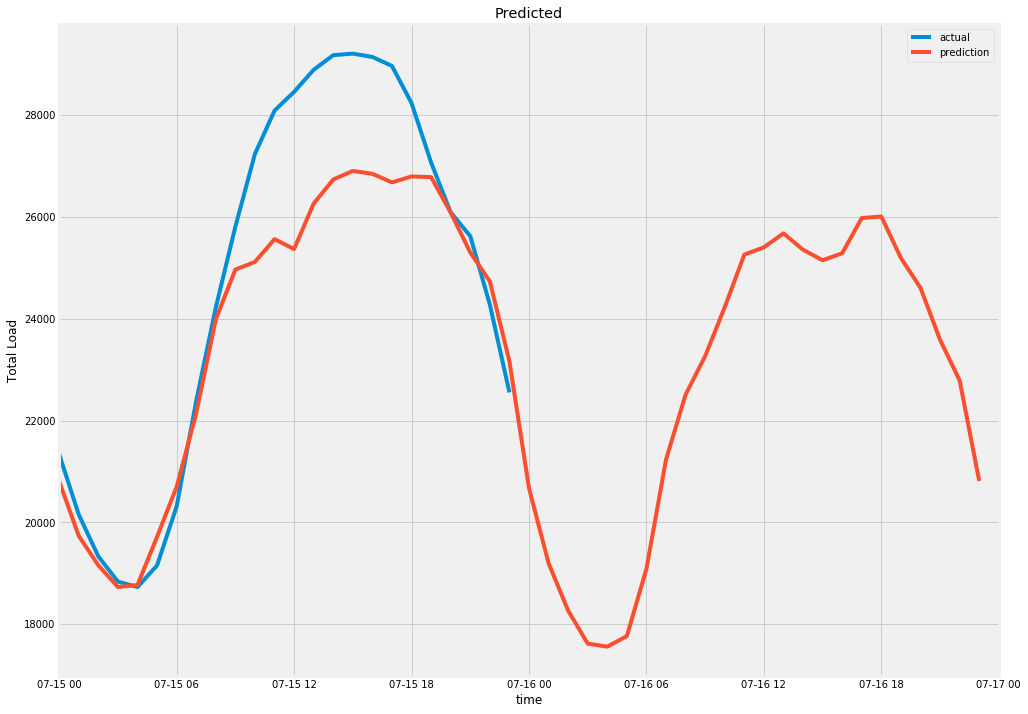

In [63]:
plt.figure(figsize=(15,12))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("Predicted")
plt.plot(x_2, act_2, '-', label='actual')
plt.plot(x_, day_fcst, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-17-2016')
plt.show()